# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

A. Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [52]:
data = pd.read_csv('telecom_churn.csv')

In [53]:
data

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


# Разбиваем и масштабируем 

In [54]:
import sklearn
import category_encoders
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder

y = data['Churn']
X = data.drop('Churn', axis=1)
num_cols = X.columns[X.dtypes != object].tolist()

In [57]:
from sklearn.base import TransformerMixin

class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [58]:
sc = CustomScaler(num_cols)
X2 = sc.fit_transform(X)

In [59]:
tgt_enc = TargetEncoder(cols=['International plan', 'Voice mail plan', 'State'])
X = tgt_enc.fit_transform(X2, y)
X

C:\Users\Lenovo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,0.185714,0.676489,-0.523603,0.114950,0.086768,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932
1,0.128205,0.149065,-0.523603,0.114950,0.086768,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932
2,0.264706,0.902529,-0.523603,0.114950,0.167151,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218
3,0.128205,-0.428590,-0.688834,0.424149,0.167151,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354
4,0.147541,-0.654629,-0.523603,0.424149,0.167151,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.062500,2.283878,-0.523603,0.114950,0.086768,2.038605,-0.432895,-1.167924,-0.433386,0.286348,1.299506,0.286880,1.547039,-0.874374,1.547188,-0.120832,0.617898,-0.125496,0.332354
3329,0.094340,-0.830437,-0.523603,0.114950,0.167151,-0.591760,0.942447,-2.164631,0.942714,-0.938353,-2.264816,-0.938172,-0.189297,1.170023,-0.188670,-0.228304,-0.194831,-0.231645,1.092641
3330,0.092308,-1.835055,1.718817,0.114950,0.167151,-0.591760,0.018820,0.426808,0.019193,1.731930,-2.114211,1.732349,-0.177431,-0.465494,-0.175486,1.383778,0.617898,1.387123,0.332354
3331,0.162162,2.082955,1.718817,0.424149,0.167151,-0.591760,0.624778,0.227466,0.625153,-0.816080,-0.808966,-0.815203,-1.219628,1.885562,-1.221396,-1.876211,2.243356,-1.876950,0.332354


## Логистическая регрессия

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

reg = LogisticRegression()
params = {'C': np.arange(0.1,3,0.1),
          'penalty':["l1","l2"]}
grid = GridSearchCV(reg, params, cv=5, scoring='f1')

grid.fit(X, y)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selecti

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [61]:
print(grid.best_params_, grid.best_score_)

{'C': 2.9000000000000004, 'penalty': 'l2'} 0.30904572087305526


In [622]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = LogisticRegression(C=2.9, penalty='l2')
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))
print('F1-score: ', f1_score(y_train, pred_train), f1_score(y_test, pred_test))

Accuracy:  0.8623405851462865 0.8785607196401799
F1-score:  0.34111310592459604 0.29565217391304355


In [623]:
from sklearn.metrics import roc_curve, auc
tpr, fpr, _ = roc_curve(y_train, reg.predict_proba(X_train)[:, 0])
auc(fpr, tpr)

0.8325999485965986

## Метод опорных векторов

In [624]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
params = {'C': np.arange(0.0001,2,0.1), 'max_iter': [100, 500, 1000, 2000, 5000, 10000]}
grid = GridSearchCV(svm, params, cv=5, scoring='f1')
grid.fit(X, y)
print(grid.best_params_)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Sol

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'C': 1.3001, 'max_iter': 2000}


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [625]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
svm = SVC(kernel='linear', C=1.3001, max_iter=2000)
svm.fit(X_train, y_train)
pred2_train = svm.predict(X_train)
pred2_test = svm.predict(X_test)

print('Accuracy: ', accuracy_score(y_train, pred2_train), accuracy_score(y_test, pred2_test))
print('F1-score: ', f1_score(y_train, pred2_train), f1_score(y_test, pred2_test))

Accuracy:  0.8075768942235559 0.8260869565217391
F1-score:  0.3039348710990502 0.3333333333333333


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


## Добавим полиномов

In [626]:
svm_new = SVC(kernel='poly')
params = {'C': np.arange(0.0001,1.1,0.1), 'degree': [2, 3, 4, 5], 'max_iter': [100, 500, 1000, 2000]}
grid = GridSearchCV(svm_new, params, cv=5, scoring='f1')
grid.fit(X, y)
print(grid.best_params_, grid.best_score_)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Sol

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Sol

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('So

{'C': 0.7001000000000001, 'degree': 3, 'max_iter': 500} 0.6119004385478893


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [628]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svc_acc = SVC(kernel='poly', C=0.7001, degree=3, max_iter=500)
svc_acc.fit(X_train, y_train)
pred3_train = svc_acc.predict(X_train)
pred3_test = svc_acc.predict(X_test)

print('Accuracy: ', accuracy_score(y_train, pred3_train), accuracy_score(y_test, pred3_test))
print('F1-score: ', f1_score(y_train, pred3_train), f1_score(y_test, pred3_test))

Accuracy:  0.9343585896474118 0.8950524737631185
F1-score:  0.7244094488188976 0.611111111111111


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


## Корреляция

<AxesSubplot:>

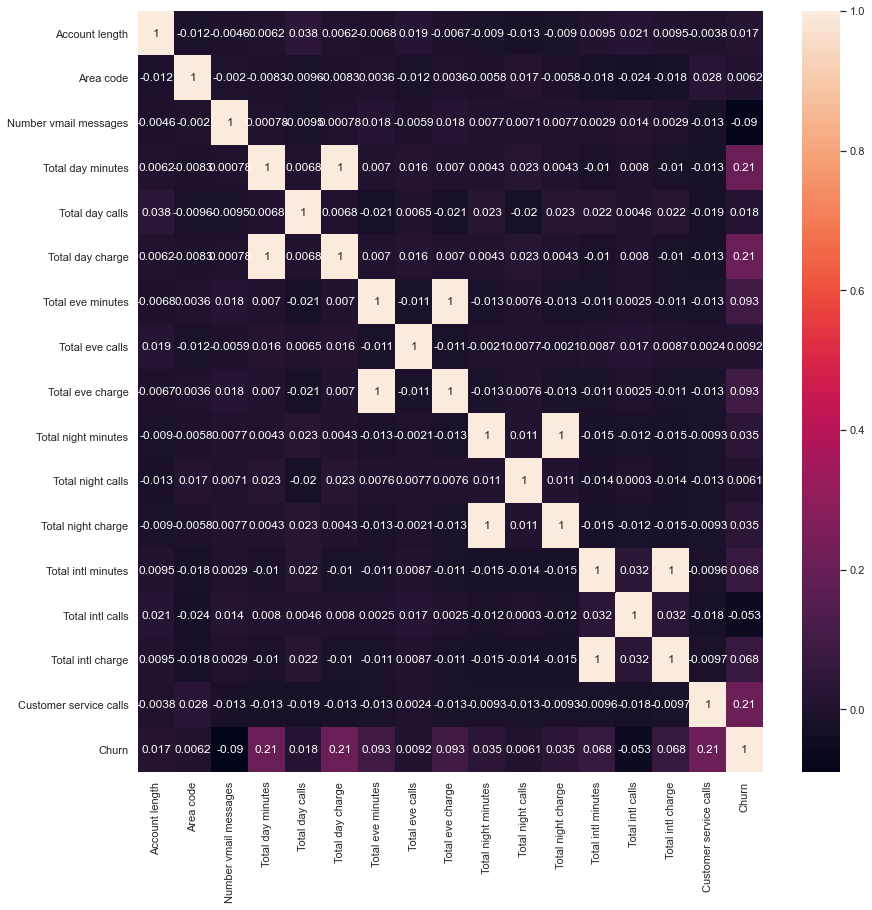

In [629]:
import seaborn as sns

corr_matrix = data.corr()
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(corr_matrix, annot=True)

In [630]:
#Удаляем те, у которых близкая к нулю корреляция с целевой переменной (<0.02)
X_new = X.drop(['Total day calls', 'Account length', 'Area code', 'Total night calls', 'Total eve calls'], axis=1)

In [631]:
#Удаляем признаки, сильно коррелирующие с другими признаками (1)
X_new = X_new.drop(['Total day charge', 'Total night charge', 'Total eve charge', 'Total intl charge'], axis=1)
X_new

,State,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total eve minutes,Total night minutes,Total intl minutes,Total intl calls,Customer service calls
0,0.185714,0.114950,0.086768,1.234883,1.566767,-0.070610,0.866743,-0.085008,-0.601195,-0.427932
1,0.128205,0.114950,0.086768,1.307948,-0.333738,-0.108080,1.058571,1.240482,-0.601195,-0.427932
2,0.264706,0.114950,0.167151,-0.591760,1.168304,-1.573383,-0.756869,0.703121,0.211534,-1.188218
3,0.128205,0.424149,0.167151,-0.591760,2.196596,-2.742865,-0.078551,-1.303026,1.024263,0.332354
4,0.147541,0.424149,0.167151,-0.591760,-0.240090,-1.038932,-0.276311,-0.049184,-0.601195,1.092641
...,...,...,...,...,...,...,...,...,...,...
3328,0.062500,0.114950,0.086768,2.038605,-0.432895,0.286348,1.547039,-0.120832,0.617898,0.332354
3329,0.094340,0.114950,0.167151,-0.591760,0.942447,-0.938353,-0.189297,-0.228304,-0.194831,1.092641
3330,0.092308,0.114950,0.167151,-0.591760,0.018820,1.731930,-0.177431,1.383778,0.617898,0.332354
3331,0.162162,0.424149,0.167151,-0.591760,0.624778,-0.816080,-1.219628,-1.876211,2.243356,0.332354


## Наудаляли, попробовали немного подругому отмасштабировать и смотрим

In [633]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

X = data.drop(['Churn', 'Total day calls', 'Account length', 'Area code',
                'Total night calls', 'Total eve calls', 'Total day charge',
                'Total night charge', 'Total eve charge', 'Total intl charge'], axis=1)
num_cols = X.columns[X.dtypes != 'int64'].tolist()
tgt_enc = TargetEncoder(cols=['State', 'International plan', 'Voice mail plan'])
X = tgt_enc.fit_transform(X, y)
stsc = ColumnTransformer([('scaler', StandardScaler(), num_cols)], remainder='passthrough')
stsc.fit_transform(X)

for i in range(2, 7):
    pipi2 = Pipeline([
        ('poly_featurizer_', PolynomialFeatures(degree=i)),
        ('scaler_', StandardScaler()),
        ('model', LogisticRegression())
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    pipi2.fit(X_train, y_train)

    y_pred_test_999 = pipi2.predict(X_test)
    y_pred_train_999 = pipi2.predict(X_train)
    tpr, fpr, _ = roc_curve(y_train, pipi2.predict_proba(X_train)[:, 0])

    print(i, ') ', 'Accuracy: ', accuracy_score(y_train, y_pred_train_999),' ', accuracy_score(y_test, y_pred_test_999), sep='')
    print('F1-score: ', f1_score(y_train, y_pred_train_999),' ', f1_score(y_test, y_pred_test_999), sep='')
    print('AUC: ', auc(fpr, tpr))

C:\Users\Lenovo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2) Accuracy: 0.9259703881552621 0.9280575539568345
F1-score: 0.704 0.7115384615384616
AUC:  0.9141893860774701
3

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


) Accuracy: 0.9515806322529011 0.9184652278177458
F1-score: 0.802610114192496 0.7235772357723578
AUC:  0.9387031574347207


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4) Accuracy: 0.9595838335334134 0.9328537170263789
F1-score: 0.8567375886524823 0.7083333333333334
AUC:  0.9562802712302227


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5) Accuracy: 0.9615846338535414 0.9400479616306955
F1-score: 0.8596491228070177 0.7549019607843137
AUC:  0.960542317799246


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


6) Accuracy: 0.9671868747499 0.9388489208633094
F1-score: 0.875 0.7792207792207793
AUC:  0.9632990451082393


<AxesSubplot:>

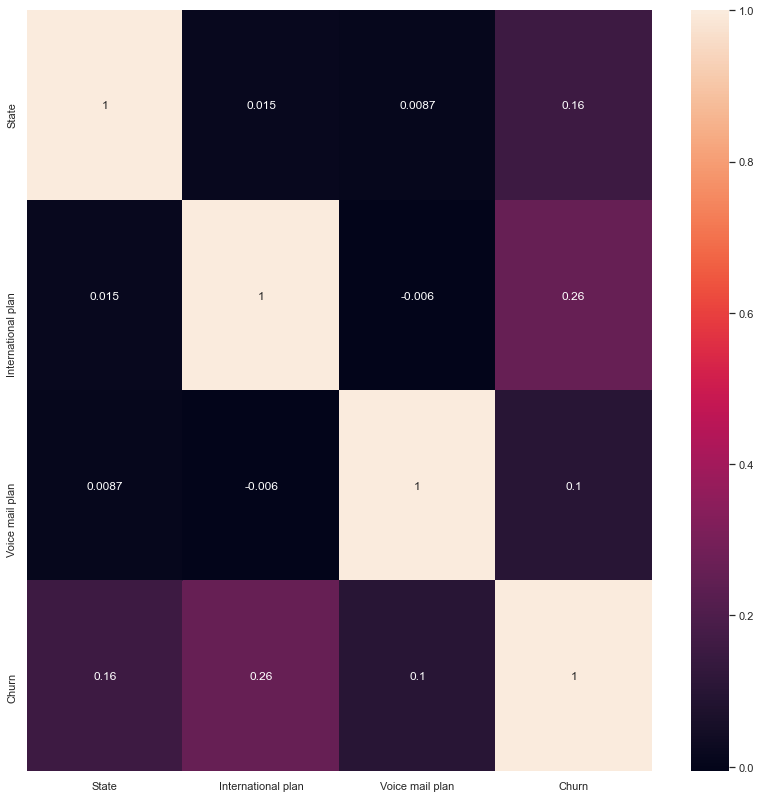

In [540]:
X_1 = X['State']
X_2 = X['International plan']
X_3 = X['Voice mail plan']
X_1 = pd.concat([X_1, X_2], sort=False, axis=1)
X_1 = pd.concat([X_1, X_3], sort=False, axis=1)
data1 = pd.concat([X_1, y], sort=False, axis=1)
corr_matrix_2 = data1.corr()
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(corr_matrix_2, annot=True)

Хорошая корреляция всех признаков (проверил, потому что в прошлую матрицу они не вошли)

## Отчёт

Изначально логистическая регрессия и метод опорных векторов показали примерно одинаковые результаты:
а) не переобучались
б) плохо предсказывали (accuracy мог быть на хорошем уровне, но это из-за несбалансированности выборки), отчего низкий f1-score

Добавив полиномов в метод опорных векторов, результаты заметно улучшились: f1-score часто выдавал значения в районе 0,6

Рассмотрев матрицу корреляций, отцепив незначимые признаки, применив немного другое масштабирование (несильно отличающееся), результаты стали совсем шикарными:
а) на полиномах 4, 5 модель выдавала значение f1-score примерно 0,75. На 6 полиноме доходило до значения 0.83
б) выросла переобученность, но это некритично - и предсказания на тесте, и  accuracy, и AUC растут.

Ваш отчет здесь.

## Часть 2. Оценка качества моделей классификации (5 баллов).

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [62]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [63]:
df.shape

(689, 21)

**Задание 1.** Проверьте target на сбалансированность по классам, сделайте вывод.

In [64]:
A = df['target'].value_counts()
print(round(100 * A[0] / 689), '% ', round(100 * A[1] / 689), '%', sep='')

55% 45%


Примерно 55% и 45%, что является хорошо сбалансированной выборкой

**Задание 2.** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [65]:
acc_1 = accuracy_score(df['target'], df['pred1_classes'])
acc_2 = accuracy_score(df['target'], df['pred2_classes'])
acc_3 = accuracy_score(df['target'], df['pred3_classes'])
print(acc_1, acc_2, acc_3)
print('Max: pred2_classes -', acc_2)

0.6618287373004355 0.6719883889695211 0.6400580551523948
Max: pred2_classes - 0.6719883889695211


**Задание 3.** Теперь вычислите точность и полноту каждого из алгоритмов.

In [66]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

pre_1 = precision_score(df['target'], df['pred1_classes'])
pre_2 = precision_score(df['target'], df['pred2_classes'])
pre_3 = precision_score(df['target'], df['pred3_classes'])
rec_1 = recall_score(df['target'], df['pred1_classes'])
rec_2 = recall_score(df['target'], df['pred2_classes'])
rec_3 = recall_score(df['target'], df['pred3_classes'])
print('У первого алгоритма: Точность', pre_1, 'Полнота', rec_1)
print('У второго алгоритма: Точность', pre_2, 'Полнота', rec_2)
print('У третьего алгоритма: Точность', pre_3, 'Полнота', rec_3)

У первого алгоритма: Точность 0.6907216494845361 Полнота 0.4364820846905538
У второго алгоритма: Точность 0.6103542234332425 Полнота 0.7296416938110749
У третьего алгоритма: Точность 0.6903225806451613 Полнота 0.3485342019543974


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4.** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [69]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

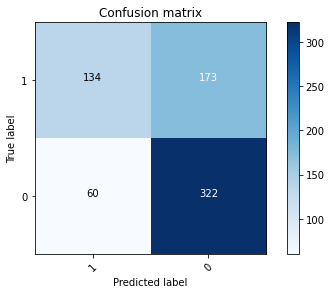

In [70]:
def TN(y_true,y_predict):
    return np.sum((y_true==0)&(y_predict==0))
 
def FP(y_true,y_predict):
    return np.sum((y_true==0)&(y_predict==1))
 
def FN(y_true,y_predict):
    return np.sum((y_true==1)&(y_predict==0))
 
def TP(y_true,y_predict):
    return np.sum((y_true==1)&(y_predict==1))

matr_1 = np.array([
        [TP(df['target'], df['pred1_classes']),FN(df['target'], df['pred1_classes'])],
        [FP(df['target'], df['pred1_classes']),TN(df['target'], df['pred1_classes'])]])
matr_2 = np.array([
        [TP(df['target'], df['pred2_classes']),FN(df['target'], df['pred2_classes'])],
        [FP(df['target'], df['pred2_classes']),TN(df['target'], df['pred2_classes'])]])
matr_3 = np.array([
        [TP(df['target'], df['pred3_classes']),FN(df['target'], df['pred3_classes'])],
        [FP(df['target'], df['pred3_classes']),TN(df['target'], df['pred3_classes'])]])


plot_confusion_matrix(matr_1, ['1', '0'])

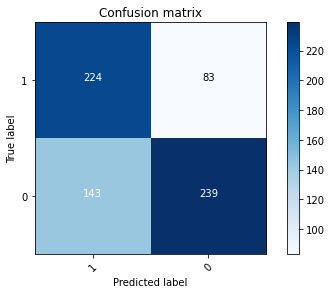

In [71]:
plot_confusion_matrix(matr_2, ['1', '0'])

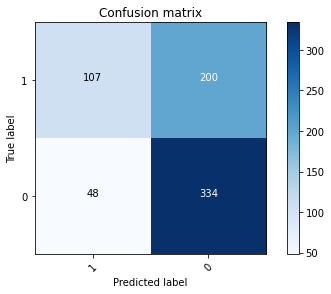

In [72]:
plot_confusion_matrix(matr_3, ['1', '0'])

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5.** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [73]:
False_neg = 173
best_p_1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred1_probs'] >= p:
            df.loc[i, 'pred1_classes'] = 1
        else:
            df.loc[i, 'pred1_classes'] = 0
    if FN(df['target'], df['pred1_classes']) < False_neg and accuracy_score(df['target'], df['pred1_classes']) >=0.65:
        best_p_1 = p
        False_neg = FN(df['target'], df['pred1_classes'])
print(best_p_1, False_neg)

0.36000099999999996 79


In [74]:
False_neg = 83
best_p_2 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred2_probs'] >= p:
            df.loc[i, 'pred2_classes'] = 1
        else:
            df.loc[i, 'pred2_classes'] = 0
    if FN(df['target'], df['pred2_classes']) < False_neg and accuracy_score(df['target'], df['pred2_classes']) >=0.65:
        best_p_2 = p
        False_neg = FN(df['target'], df['pred2_classes'])
print(best_p_2, False_neg)

0.270001 50


In [75]:
False_neg = 200
best_p_3 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred3_probs'] >= p:
            df.loc[i, 'pred3_classes'] = 1
        else:
            df.loc[i, 'pred3_classes'] = 0
    if FN(df['target'], df['pred3_classes']) < False_neg and accuracy_score(df['target'], df['pred3_classes']) >=0.64:
        best_p_3 = p
        False_neg = FN(df['target'], df['pred3_classes'])
print(best_p_3, False_neg)

0.230001 110


Стоит отметить, что алгоритм 3 не может выдать accuracy нужного значения, поэтому я его снизил до 0.64

### Хотелось бы отметить
Простая минимизация FN не всегда тождественна максимизации recall (даже с ограничением на accuracy). Поэтому для ответа на вопрос про максимальную полноту стоит пересмотреть решение

In [76]:
rec_score_1 = 0
best_p_1_ex = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred1_probs'] >= p:
            df.loc[i, 'pred1_classes'] = 1
        else:
            df.loc[i, 'pred1_classes'] = 0
    if recall_score(df['target'], df['pred1_classes']) > rec_score_1 and accuracy_score(df['target'], df['pred1_classes']) >=0.65:
        best_p_1_ex = p
        rec_score_1 = recall_score(df['target'], df['pred1_classes'])
print(best_p_1_ex, rec_score_1)

0.36000099999999996 0.742671009771987


In [77]:
rec_score_2 = 0
best_p_2_ex = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred2_probs'] >= p:
            df.loc[i, 'pred2_classes'] = 1
        else:
            df.loc[i, 'pred2_classes'] = 0
    if recall_score(df['target'], df['pred2_classes']) > rec_score_2 and accuracy_score(df['target'], df['pred2_classes']) >=0.65:
        best_p_2_ex = p
        rec_score_2 = recall_score(df['target'], df['pred2_classes'])
print(best_p_2_ex, rec_score_2)

0.270001 0.8371335504885994


In [78]:
rec_score_3 = 0
best_p_3_ex = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred3_probs'] >= p:
            df.loc[i, 'pred3_classes'] = 1
        else:
            df.loc[i, 'pred3_classes'] = 0
    if recall_score(df['target'], df['pred3_classes']) > rec_score_3 and accuracy_score(df['target'], df['pred3_classes']) >=0.64:
        best_p_3_ex = p
        rec_score_3 = recall_score(df['target'], df['pred3_classes'])
print(best_p_3_ex, rec_score_3)

0.230001 0.6416938110749185


#### В этот раз прокатило

**Задание 6.** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

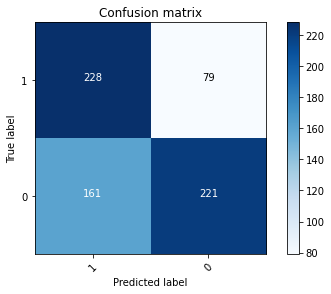

In [79]:
for i in range(0, df.shape[0]):
    if df.loc[i, 'pred1_probs'] >= best_p_1:
        df.loc[i, 'pred1_classes'] = 1
    else:
        df.loc[i, 'pred1_classes'] = 0

for i in range(0, df.shape[0]):
    if df.loc[i, 'pred2_probs'] >= best_p_2:
        df.loc[i, 'pred2_classes'] = 1
    else:
        df.loc[i, 'pred2_classes'] = 0

for i in range(0, df.shape[0]):
    if df.loc[i, 'pred3_probs'] >= best_p_3:
        df.loc[i, 'pred3_classes'] = 1
    else:
        df.loc[i, 'pred3_classes'] = 0
        
matr_1_1 = np.array([
        [TP(df['target'], df['pred1_classes']),FN(df['target'], df['pred1_classes'])],
        [FP(df['target'], df['pred1_classes']),TN(df['target'], df['pred1_classes'])]])
matr_2_1 = np.array([
        [TP(df['target'], df['pred2_classes']),FN(df['target'], df['pred2_classes'])],
        [FP(df['target'], df['pred2_classes']),TN(df['target'], df['pred2_classes'])]])
matr_3_1 = np.array([
        [TP(df['target'], df['pred3_classes']),FN(df['target'], df['pred3_classes'])],
        [FP(df['target'], df['pred3_classes']),TN(df['target'], df['pred3_classes'])]])

plot_confusion_matrix(matr_1_1, ['1', '0'])

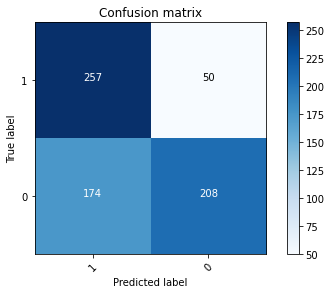

In [80]:
plot_confusion_matrix(matr_2_1, ['1', '0'])

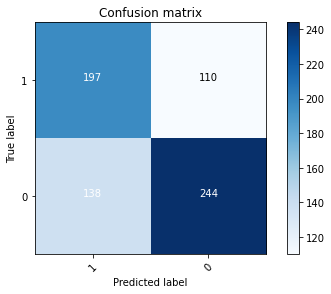

In [81]:
plot_confusion_matrix(matr_3_1, ['1', '0'])

**Выводы:** здесь напишите, какая модель лучше всего справилась с поставленной задачей.

С задачей лучше всего справилась вторая модель, которая выдала наибольшее значение TP (левый верхний угол) и наименьшее значение FN (важно, что он находится в верхнем правом углу, в связи с изначальными названиями осей графика, которые не соответсвуют уточнению в условии) при хорошей точности прогноза

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7.** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [82]:
False_pos = 200
best_p_1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred1_probs'] >= p:
            df.loc[i, 'pred1_classes'] = 1
        else:
            df.loc[i, 'pred1_classes'] = 0
    if FP(df['target'], df['pred1_classes']) < False_pos and accuracy_score(df['target'], df['pred1_classes']) >=0.65:
        best_p_1 = p
        False_pos = FP(df['target'], df['pred1_classes'])
print(best_p_1, False_pos)

0.5500010000000001 39


In [83]:
False_pos = 200
best_p_2 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred2_probs'] >= p:
            df.loc[i, 'pred2_classes'] = 1
        else:
            df.loc[i, 'pred2_classes'] = 0
    if FP(df['target'], df['pred2_classes']) < False_pos and accuracy_score(df['target'], df['pred2_classes']) >=0.65:
        best_p_2 = p
        False_pos = FP(df['target'], df['pred2_classes'])
print(best_p_2, False_pos)

0.730001 16


In [84]:
False_pos = 200
best_p_3 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred3_probs'] >= p:
            df.loc[i, 'pred3_classes'] = 1
        else:
            df.loc[i, 'pred3_classes'] = 0
    if FP(df['target'], df['pred3_classes']) < False_pos and accuracy_score(df['target'], df['pred3_classes']) >=0.64:
        best_p_3 = p
        False_pos = FP(df['target'], df['pred3_classes'])
print(best_p_3, False_pos)

0.5600010000000001 40


### Хотелось бы снова отметить
Минимизация FP не всегда равно максимизации precision

In [85]:
prec_score_1 = 0
best_p_1_ex_1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred1_probs'] >= p:
            df.loc[i, 'pred1_classes'] = 1
        else:
            df.loc[i, 'pred1_classes'] = 0
    if precision_score(df['target'], df['pred1_classes']) > prec_score_1 and accuracy_score(df['target'], df['pred1_classes']) >=0.65:
        best_p_1_ex_1 = p
        prec_score_1 = precision_score(df['target'], df['pred1_classes'])
print(best_p_1_ex_1, prec_score_1)

0.5400010000000001 0.7371794871794872


In [86]:
prec_score_2 = 0
best_p_2_ex_1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred2_probs'] >= p:
            df.loc[i, 'pred2_classes'] = 1
        else:
            df.loc[i, 'pred2_classes'] = 0
    if precision_score(df['target'], df['pred2_classes']) > prec_score_2 and accuracy_score(df['target'], df['pred2_classes']) >=0.65:
        best_p_2_ex_1 = p
        prec_score_2 = precision_score(df['target'], df['pred2_classes'])
print(best_p_2_ex_1, prec_score_2)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.730001 0.8367346938775511


In [87]:
prec_score_3 = 0
best_p_3_ex_1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred3_probs'] >= p:
            df.loc[i, 'pred3_classes'] = 1
        else:
            df.loc[i, 'pred3_classes'] = 0
    if precision_score(df['target'], df['pred3_classes']) > prec_score_3 and accuracy_score(df['target'], df['pred3_classes']) >=0.64:
        best_p_3_ex_1 = p
        prec_score_3 = precision_score(df['target'], df['pred3_classes'])
print(best_p_3_ex_1, prec_score_3)

0.5600010000000001 0.7142857142857143


#### А вот тут не прокатило с моделью 1 (порог при минимизации FP = 0.55, а при максимизации precision_score = 0.54). Нужна доп проверка в матрицах

**Задание 8.** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

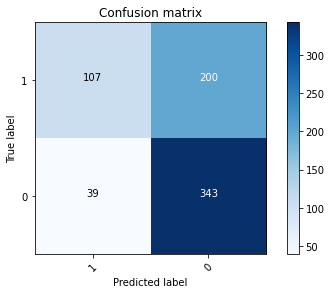

In [88]:
for i in range(0, df.shape[0]):
    if df.loc[i, 'pred1_probs'] >= best_p_1:
        df.loc[i, 'pred1_classes'] = 1
    else:
        df.loc[i, 'pred1_classes'] = 0

for i in range(0, df.shape[0]):
    if df.loc[i, 'pred2_probs'] >= best_p_2:
        df.loc[i, 'pred2_classes'] = 1
    else:
        df.loc[i, 'pred2_classes'] = 0

for i in range(0, df.shape[0]):
    if df.loc[i, 'pred3_probs'] >= best_p_3:
        df.loc[i, 'pred3_classes'] = 1
    else:
        df.loc[i, 'pred3_classes'] = 0
        
matr_1_2 = np.array([
        [TP(df['target'], df['pred1_classes']),FN(df['target'], df['pred1_classes'])],
        [FP(df['target'], df['pred1_classes']),TN(df['target'], df['pred1_classes'])]])
matr_2_2 = np.array([
        [TP(df['target'], df['pred2_classes']),FN(df['target'], df['pred2_classes'])],
        [FP(df['target'], df['pred2_classes']),TN(df['target'], df['pred2_classes'])]])
matr_3_2 = np.array([
        [TP(df['target'], df['pred3_classes']),FN(df['target'], df['pred3_classes'])],
        [FP(df['target'], df['pred3_classes']),TN(df['target'], df['pred3_classes'])]])

plot_confusion_matrix(matr_1_2, ['1', '0'])

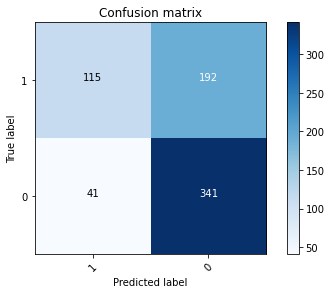

In [89]:
#доп проверка
for i in range(0, df.shape[0]):
    if df.loc[i, 'pred1_probs'] >= best_p_1_ex_1:
        df.loc[i, 'pred1_classes'] = 1
    else:
        df.loc[i, 'pred1_classes'] = 0

        
matr_1_2_1 = np.array([
        [TP(df['target'], df['pred1_classes']),FN(df['target'], df['pred1_classes'])],
        [FP(df['target'], df['pred1_classes']),TN(df['target'], df['pred1_classes'])]])
plot_confusion_matrix(matr_1_2_1, ['1', '0'])

##### Получается, что при минимизации FP у нас снижается значение FP на 2 по сравнению с максимизацией precision, но при этом уменьшается и значение TP, но уже на целых 8 пунктов!

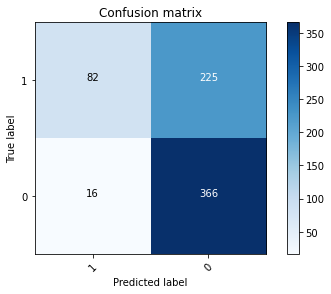

In [90]:
plot_confusion_matrix(matr_2_2, ['1', '0'])

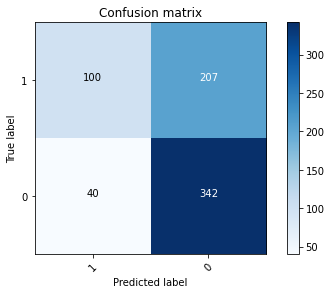

In [91]:
plot_confusion_matrix(matr_3_2, ['1', '0'])

Со второй задачей опять же лучше всего справляется вторая модель (меньше всего FP), однако стоит отметить, что она из-за этого жертвует кол-вом выданных кредитов (самая низкая TP).

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9.** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [94]:
F1_1 = 0
best_p_1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred1_probs'] >= p:
            df.loc[i, 'pred1_classes'] = 1
        else:
            df.loc[i, 'pred1_classes'] = 0
    if f1_score(df['target'], df['pred1_classes']) > F1_1:
        best_p_1 = p
        F1_1 = f1_score(df['target'], df['pred1_classes'])
print(best_p_1, F1_1)

0.340001 0.672


In [95]:
F1_2 = 0
best_p_2 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred2_probs'] >= p:
            df.loc[i, 'pred2_classes'] = 1
        else:
            df.loc[i, 'pred2_classes'] = 0
    if f1_score(df['target'], df['pred2_classes']) > F1_2:
        best_p_2 = p
        F1_2 = f1_score(df['target'], df['pred2_classes'])
print(best_p_2, F1_2)

0.320001 0.6990291262135923


In [96]:
F1_3 = 0
best_p_3 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, df.shape[0]):
        if df.loc[i, 'pred3_probs'] >= p:
            df.loc[i, 'pred3_classes'] = 1
        else:
            df.loc[i, 'pred3_classes'] = 0
    if f1_score(df['target'], df['pred3_classes']) > F1_3:
        best_p_3 = p
        F1_3 = f1_score(df['target'], df['pred3_classes'])
print(best_p_3, F1_3)

0.150001 0.6443418013856813


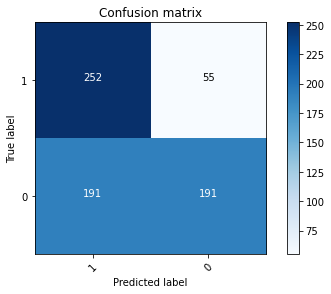

In [97]:
for i in range(0, df.shape[0]):
    if df.loc[i, 'pred1_probs'] >= best_p_1:
        df.loc[i, 'pred1_classes'] = 1
    else:
        df.loc[i, 'pred1_classes'] = 0

for i in range(0, df.shape[0]):
    if df.loc[i, 'pred2_probs'] >= best_p_2:
        df.loc[i, 'pred2_classes'] = 1
    else:
        df.loc[i, 'pred2_classes'] = 0

for i in range(0, df.shape[0]):
    if df.loc[i, 'pred3_probs'] >= best_p_3:
        df.loc[i, 'pred3_classes'] = 1
    else:
        df.loc[i, 'pred3_classes'] = 0
        
matr_1_3 = np.array([
        [TP(df['target'], df['pred1_classes']),FN(df['target'], df['pred1_classes'])],
        [FP(df['target'], df['pred1_classes']),TN(df['target'], df['pred1_classes'])]])
matr_2_3 = np.array([
        [TP(df['target'], df['pred2_classes']),FN(df['target'], df['pred2_classes'])],
        [FP(df['target'], df['pred2_classes']),TN(df['target'], df['pred2_classes'])]])
matr_3_3 = np.array([
        [TP(df['target'], df['pred3_classes']),FN(df['target'], df['pred3_classes'])],
        [FP(df['target'], df['pred3_classes']),TN(df['target'], df['pred3_classes'])]])

plot_confusion_matrix(matr_1_3, ['1', '0'])

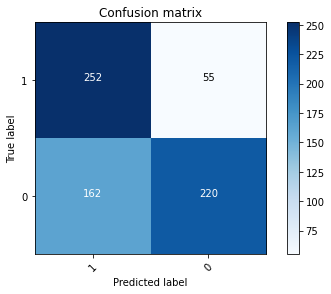

In [98]:
plot_confusion_matrix(matr_2_3, ['1', '0'])

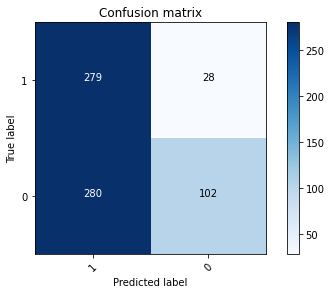

In [99]:
plot_confusion_matrix(matr_3_3, ['1', '0'])

И опять наилучший результат у модели номер 2.

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [100]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61       382
           1       0.57      0.82      0.67       307

    accuracy                           0.64       689
   macro avg       0.67      0.66      0.64       689
weighted avg       0.68      0.64      0.64       689



### Обучим свою модель для предсказания target.

**Задание 10.** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

df = pd.read_csv("credit_scoring_example1.csv")

y = df['target']
X = df.drop(['target', 'pred1_probs', 'pred1_classes', 'pred2_probs', 'pred2_classes', 'pred3_probs', 'pred3_classes'], axis=1)
num_cols = X.columns[X.dtypes != object].tolist()
stsc = ColumnTransformer([('scaler', StandardScaler(), num_cols)], remainder='passthrough')
X = stsc.fit_transform(X)
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.689474,-0.800189,1.345702,0.543460,-0.915390,-0.348248,-0.190685,-1.049099,-0.865292,-0.494332,1.089634,0.238010,-0.487079,0.037071
1,-1.450381,-0.750225,0.449679,0.543460,0.170626,-0.348248,-0.615008,-1.049099,-0.865292,-0.494332,-0.917740,0.238010,-0.138406,-0.195561
2,-1.450381,-0.165051,-0.605056,-1.782279,-0.915390,-0.348248,-0.290789,-1.049099,-0.865292,-0.494332,1.089634,0.238010,0.558939,-0.195561
3,-1.450381,-0.834910,1.353739,-1.782279,-0.643886,-0.850220,-0.664313,0.953198,1.155679,1.768074,1.089634,0.238010,-1.068200,-0.195561
4,0.689474,-0.961938,0.684735,0.543460,-0.372382,-0.348248,-0.078628,0.953198,1.155679,2.385094,-0.917740,0.238010,-0.719527,-0.165234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.689474,0.003472,1.152837,0.543460,1.799650,-0.348248,1.278011,0.953198,-0.865292,-0.494332,-0.917740,0.238010,-1.068200,-0.195561
685,0.689474,-0.919595,-0.873260,0.543460,0.170626,-0.348248,-0.626961,-1.049099,-0.865292,-0.494332,-0.917740,0.238010,-1.068200,-0.187115
686,-1.450381,-1.075416,0.959971,0.543460,-0.372382,-0.348248,-0.638914,0.953198,-0.865292,-0.494332,-0.917740,0.238010,-0.487079,-0.195561
687,-1.450381,-0.347971,1.956445,0.543460,1.799650,1.659642,0.257544,0.953198,1.155679,-0.288659,-0.917740,0.238010,-0.370855,-0.193449


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg_2 = LogisticRegression()
reg_2.fit(X_train, y_train)
target_pred_test = reg_2.predict_proba(X_test)
A = pd.DataFrame(target_pred_test[:,1])
A['target'] = y_test.to_numpy()


In [119]:
A = (A.rename(columns={0: 'New_pred'})
     .assign(my_tg = A['target']))
A

,New_pred,target,my_tg
0,0.020024,0,0
1,0.950164,1,1
2,0.911675,1,1
3,0.918055,1,1
4,0.851631,0,0
...,...,...,...
168,0.668228,1,1
169,0.019037,0,0
170,0.061871,0,0
171,0.601119,1,1


**Задание 11.** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [120]:
best_prec = 0
best_p_prec = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, A.shape[0]):
        if A.loc[i, 'New_pred'] >= p:
            A.loc[i, 'my_tg'] = 1
        else:
            A.loc[i, 'my_tg'] = 0
    if precision_score(A['target'], A['my_tg']) > best_prec:
        best_p_prec = p
        best_prec = precision_score(A['target'], A['my_tg'])
print('Порог для точности:', best_p_prec,'Точность:', best_prec)

best_rec = 0
best_p_rec = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, A.shape[0]):
        if A.loc[i, 'New_pred'] >= p:
            A.loc[i, 'my_tg'] = 1
        else:
            A.loc[i, 'my_tg'] = 0
    if recall_score(A['target'], A['my_tg']) > best_rec:
        best_p_rec = p
        best_rec = recall_score(A['target'], A['my_tg'])
print('Порог для полноты:', best_p_rec,'Полнота:', best_rec)

best_f1 = 0
best_p_f1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, A.shape[0]):
        if A.loc[i, 'New_pred'] >= p:
            A.loc[i, 'my_tg'] = 1
        else:
            A.loc[i, 'my_tg'] = 0
    if f1_score(A['target'], A['my_tg']) > best_f1:
        best_p_f1 = p
        best_f1 = f1_score(A['target'], A['my_tg'])
print('Порог для F-меры:', best_p_f1,'F-мера:', best_f1)

Порог для точности: 0.970001 Точность: 1.0
Порог для полноты: 1e-06 Полнота: 1.0
Порог для F-меры: 0.37000099999999997 F-мера: 0.8888888888888888


Значения для точности и полноты получились не интересные, поэтому введем условие на accuracy >= 0.8

In [121]:
best_prec = 0
best_p_prec = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, A.shape[0]):
        if A.loc[i, 'New_pred'] >= p:
            A.loc[i, 'my_tg'] = 1
        else:
            A.loc[i, 'my_tg'] = 0
    if precision_score(A['target'], A['my_tg']) > best_prec and accuracy_score(A['target'], A['my_tg']) >= 0.8:
        best_p_prec = p
        best_prec = precision_score(A['target'], A['my_tg'])
print('Порог для точности:', best_p_prec,'Точность:', best_prec)

best_rec = 0
best_p_rec = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, A.shape[0]):
        if A.loc[i, 'New_pred'] >= p:
            A.loc[i, 'my_tg'] = 1
        else:
            A.loc[i, 'my_tg'] = 0
    if recall_score(A['target'], A['my_tg']) > best_rec and accuracy_score(A['target'], A['my_tg']) >= 0.8:
        best_p_rec = p
        best_rec = recall_score(A['target'], A['my_tg'])
print('Порог для полноты:', best_p_rec,'Полнота:', best_rec)

best_f1 = 0
best_p_f1 = 0.5
for p in np.arange(0.000001, 1, 0.01):
    for i in range(0, A.shape[0]):
        if A.loc[i, 'New_pred'] >= p:
            A.loc[i, 'my_tg'] = 1
        else:
            A.loc[i, 'my_tg'] = 0
    if f1_score(A['target'], A['my_tg']) > best_f1 and accuracy_score(A['target'], A['my_tg']) >= 0.8:
        best_p_f1 = p
        best_f1 = f1_score(A['target'], A['my_tg'])
print('Порог для F-меры:', best_p_f1,'F-мера:', best_f1)

Порог для точности: 0.740001 Точность: 0.9473684210526315
Порог для полноты: 0.110001 Полнота: 0.9605263157894737
Порог для F-меры: 0.37000099999999997 F-мера: 0.8888888888888888


## Выводы

Логистическая регрессия сработала сильно лучше предложенных алгоритмов. При более строгом условии accuracy (0.8 вместо 0.65) значения и точности, и полноты заметно увеличились. Аналогичная ситуация наблюдается и со значением F-меры, которая увеличилась со значения 0.69 (второй алгоритм) до значения 0.89.